### Data Link: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?select=Meta.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
zip_path = "/content/drive/MyDrive/Elevvo_Internship_ML/Germansign.zip"
extract_path = "/content/GTSRB"

In [3]:
!unzip -q "$zip_path" -d "$extract_path"
print("Extraction complete! Files are in:", extract_path)

Extraction complete! Files are in: /content/GTSRB


In [4]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2

In [6]:
base_path   = "/content/GTSRB/Germansign"
train_dir   = os.path.join(base_path, "Train")
test_dir    = os.path.join(base_path, "Test")
train_csv   = os.path.join(base_path, "Train.csv")
test_csv    = os.path.join(base_path, "Test.csv")
meta_csv    = os.path.join(base_path, "Meta.csv")

print("Train folders:", len(os.listdir(train_dir)))
print("Example class folder:", os.listdir(os.path.join(train_dir, "38"))[:3])

Train folders: 43
Example class folder: ['00038_00020_00006.png', '00038_00063_00008.png', '00038_00064_00011.png']


In [7]:
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)
meta_df  = pd.read_csv(meta_csv)

In [8]:
train_df.head(2)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png


In [9]:
test_df.head(2)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png


In [10]:
meta_df.head(2)

,Path,ClassId,ShapeId,ColorId,SignId
0,Meta/27.png,27,0,0,1.32
1,Meta/0.png,0,1,0,3.29


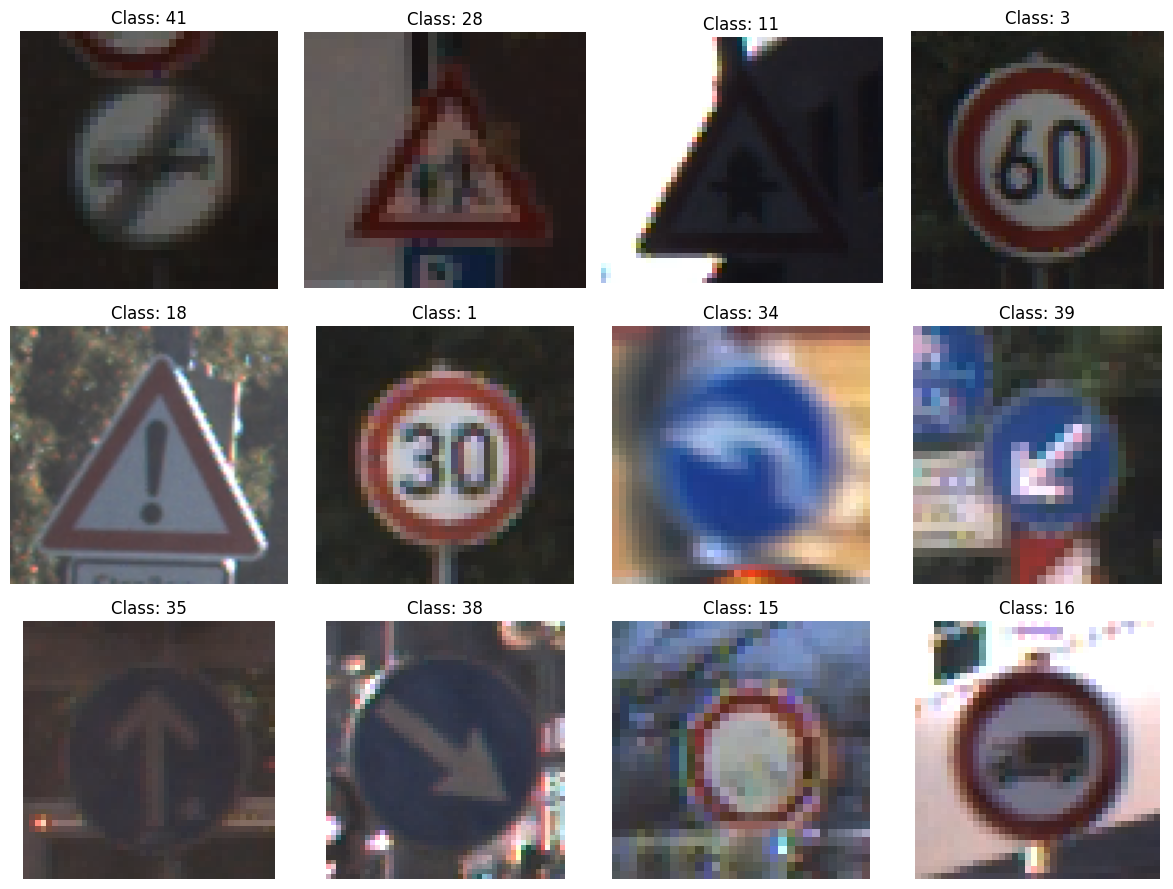

In [11]:
# Get a list of all class folders
all_classes = os.listdir(train_dir)

random_classes = random.sample(all_classes, 12)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for i, class_name in enumerate(random_classes):
    class_path = os.path.join(train_dir, class_name)

    images_in_class = os.listdir(class_path)

    random_image_name = random.choice(images_in_class)
    random_image_path = os.path.join(class_path, random_image_name)

    img = cv2.imread(random_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

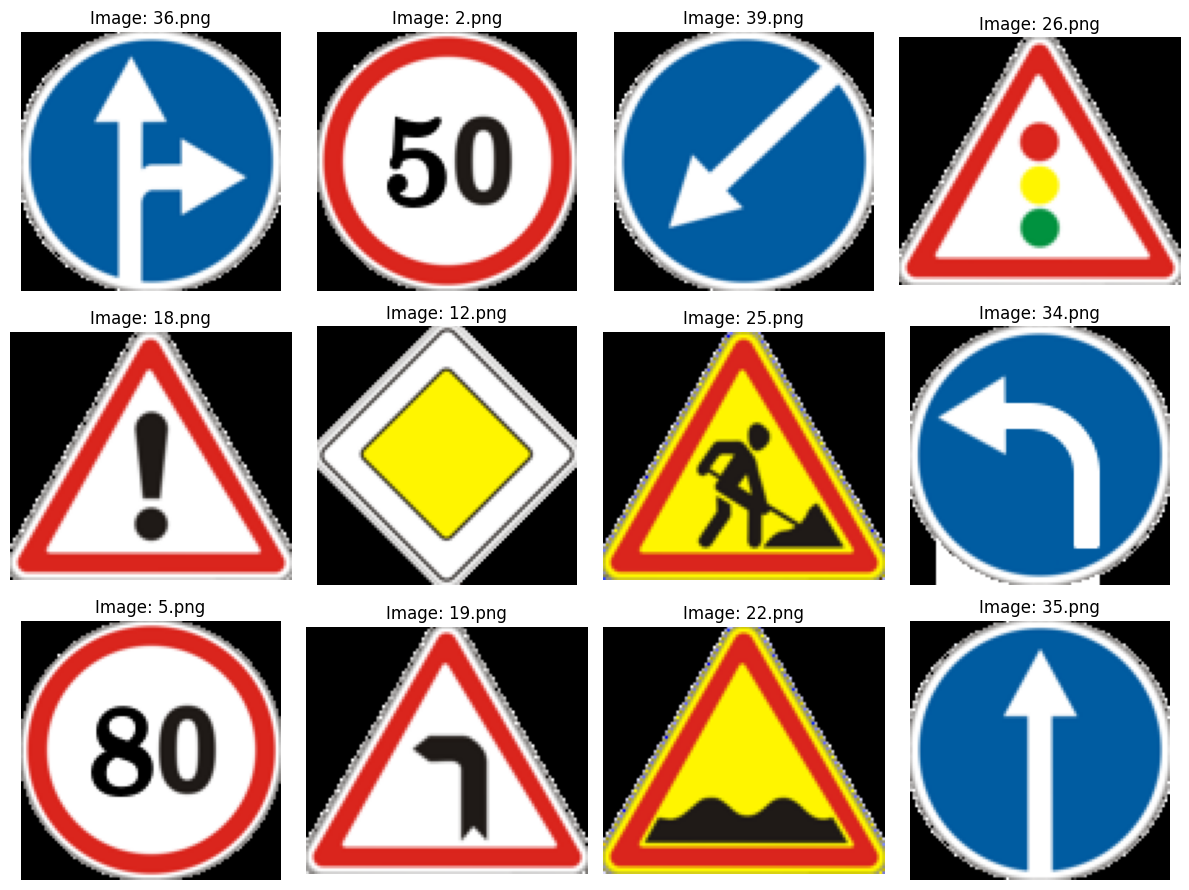

In [12]:
meta_dir = os.path.join(base_path, "Meta")
meta_images = os.listdir(meta_dir)

# Randomly select 12 images from the meta folder(Which has more clearer picture)
random_meta_images = random.sample(meta_images, 12)

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.ravel()

for i, image_name in enumerate(random_meta_images):
    image_path = os.path.join(meta_dir, image_name)

    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].set_title(f"Image: {image_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [14]:
img_size = (30,30)
batch_size = 32

datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    validation_split=0.2
)


train_gen = datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = "training"
)

val_gen = datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True,
    subset = "validation"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_df['ClassId'] = test_df['ClassId'].astype(str)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    directory=base_path,
    x_col='Path',
    y_col='ClassId',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.
Found 12630 validated image filenames belonging to 43 classes.


In [22]:
input_tensor = Input(shape=(30,30,3))

x = Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.0001))(input_tensor)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)

output = Dense(43, activation='softmax')(x)

model_reg = Model(inputs=input_tensor, outputs=output)

model_reg.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_reg.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 15, 15, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 400,363 (1.53 MB)

 Trainable params: 399,915 (1.53 MB)

 Non-trainable params: 448 (1.75 KB)

**Reasoning**:
The new model with regularization and dropout has been defined and compiled. The next step is to train this new model using the previously prepared data generators.



In [23]:
history_reg = model_reg.fit(train_gen,
                            validation_data=val_gen,
                            epochs=25,
                            verbose=1
                           )

Epoch 1/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.1677 - loss: 3.1204 - val_accuracy: 0.3220 - val_loss: 2.1481
Epoch 2/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.4173 - loss: 1.8184 - val_accuracy: 0.4346 - val_loss: 1.7585
Epoch 3/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.5156 - loss: 1.4777 - val_accuracy: 0.5183 - val_loss: 1.4902
Epoch 4/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.5899 - loss: 1.2522 - val_accuracy: 0.5812 - val_loss: 1.2901
Epoch 5/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6356 - loss: 1.1166 - val_accuracy: 0.6073 - val_loss: 1.2610
Epoch 6/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.6737 - loss: 1.0075 - val_accuracy: 0.6180 - val_loss: 1.2525
Epoch 7/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.6997 - loss: 0.9313 - val_accuracy: 0.6418 - val_loss: 1.1261
Epoch 8/25
981/981 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.7262 - loss: 0.8630 - 

In [24]:
test_scores = model_reg.evaluate(test_gen, verbose=1)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.8618 - loss: 0.6178
Test loss: 0.6372693777084351
Test accuracy: 0.8605700731277466
